In [7]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
import random

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 100
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.Method = 1        
    model.Params.MIPFocus = 1        
    model.Params.Heuristics = 0.8   
    model.Params.Threads = 8

In [2]:
# Parameters
m = 15
K = 5
L_levels = [20, 15, 10, 5, 1]  
E_levels = [13, 28, 38, 45, 120] 
E_PU_max = [8000] * m # limit 650
CPU_capacity = [3000] * m
f_v_levels = [15, 20, 30, 40, 60]
P_idle = [18] * m
P_max = [36] * m
T_total = 300
total_tasks = 100
from collections import Counter

# Task chain definitions
chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}

num_chains = len(chain_tasks)
n = max(max(v) for v in chain_tasks.values()) + 1  # Total number of tasks
L_max = [len(chain_tasks[k]) * 6.5 for k in chain_tasks]  # Max delay per chain




def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = gp.Model("MAF_Optimization")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")

    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # Ensure y[i,k]=0 if task is inactive

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])

    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )

    start_time = time.time()
    model.optimize()
    end_time = time.time()

    if model.status != GRB.OPTIMAL:
        print("❌ Model optimization failed. Skipping variable access.")
        return None

    print(f"⏱️ Gurobi Runtime: {end_time - start_time:.2f} seconds")
    print("\n📋 Chain Activation Overview:")
    for k in range(num_chains):
        status = "✅ Activated" if z[k].X > 0.5 else "❌ Not activated"
        task_list = chain_tasks[k]
        print(f"Chain {k}: {status}, Tasks: {task_list}")

    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
        pu_task_map.setdefault(pu_id, []).append(task_id)

    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]

    return {
        "Mode": "Baseline" if baseline else "Non-Baseline",
        "Objective Value": model.ObjVal,
        "Accepted Chains": len(accepted_chains),
        "Total PU Energy": sum(E_PU[j].X for j in range(m)),
        "Total Task Energy": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
        "Runtime": model.Runtime,
        "PU Task Assignment": pu_task_map,
        "Task Energy Levels": task_energy_levels,
        "Activated Chain List": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)]
    }




 

In [3]:
from collections import Counter

def visualize_baseline_vs_optimal_extended_v4_en(baseline_result, optimal_result, num_chains):
    labels = ["Baseline", "Optimal"]
    colors = ["#5DADE2", "#F5B041"]

    # Data extraction
    times = [baseline_result["Runtime"], optimal_result["Runtime"]]
    acceptance = [
        baseline_result["Accepted Chains"] / num_chains,
        optimal_result["Accepted Chains"] / num_chains
    ]
    total_energy = [
        baseline_result["Total Task Energy"] + baseline_result["Total PU Energy"],
        optimal_result["Total Task Energy"] + optimal_result["Total PU Energy"]
    ]
    saving_values = [
        0,
        (total_energy[0] - total_energy[1]) / total_energy[0] * 100
    ]
    objective_values = [baseline_result["Objective Value"], optimal_result["Objective Value"]]

    # PU assignment count
    baseline_pu_counts = {k: len(tasks) for k, tasks in baseline_result["PU Task Assignment"].items()}
    optimal_pu_counts = {k: len(tasks) for k, tasks in optimal_result["PU Task Assignment"].items()}
    pu_ids = sorted(set(baseline_pu_counts.keys()) | set(optimal_pu_counts.keys()))
    baseline_pu_values = [baseline_pu_counts.get(i, 0) for i in pu_ids]
    optimal_pu_values = [optimal_pu_counts.get(i, 0) for i in pu_ids]

    # Energy level count
    baseline_energy_levels = [e for e in baseline_result["Task Energy Levels"] if e >= 0]
    optimal_energy_levels = [e for e in optimal_result["Task Energy Levels"] if e >= 0]
    K = max(baseline_energy_levels + optimal_energy_levels) + 1
    energy_levels = list(range(K))
    baseline_energy_counter = Counter(baseline_energy_levels)
    optimal_energy_counter = Counter(optimal_energy_levels)
    baseline_energy_counts = [baseline_energy_counter.get(k, 0) for k in energy_levels]
    optimal_energy_counts = [optimal_energy_counter.get(k, 0) for k in energy_levels]

    # Chain activation
    baseline_chain_activation = baseline_result["Activated Chain List"]
    optimal_chain_activation = optimal_result["Activated Chain List"]
    chain_ids = np.arange(1, num_chains + 1)

    fig, axs = plt.subplots(3, 3, figsize=(18, 15))

    # Execution Time
    axs[0, 0].bar(labels, times, color=colors)
    axs[0, 0].set_title("Execution Time (s)")
    axs[0, 0].set_ylabel("Time (s)")
    for i, v in enumerate(times):
        axs[0, 0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

    # Chain Acceptance Rate
    axs[0, 1].bar(labels, acceptance, color=colors)
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].set_ylabel("Ratio")
    for i, v in enumerate(acceptance):
        axs[0, 1].text(i, v, f"{v:.1%}", ha='center', va='bottom')

    # Objective Function
    axs[2, 0].bar(labels, objective_values, color=colors)
    axs[2, 0].set_title("Objective Function Value")
    axs[2, 0].set_ylabel("Objective Value")
    for i, v in enumerate(objective_values):
        axs[2, 0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

    # Total Energy
    axs[0, 2].bar(labels, total_energy, color=colors)
    axs[0, 2].set_title("Total Energy Consumption")
    axs[0, 2].set_ylabel("Energy")
    for i, v in enumerate(total_energy):
        axs[0, 2].text(i, v, f"{v:.1f}", ha='center', va='bottom')

    # Energy Saving %
    axs[1, 0].bar(labels, saving_values, color=colors)
    axs[1, 0].set_title("Energy Saving Compared to Baseline (%)")
    axs[1, 0].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axs[1, 0].set_ylabel("Saving (%)")
    for i, v in enumerate(saving_values):
        axs[1, 0].text(i, v, f"{v:.2f}%", ha='center', va='bottom')

    # PU Task Assignment
    width = 0.35
    x = np.arange(len(pu_ids))
    axs[1, 1].bar(x - width/2, baseline_pu_values, width=width, label='Baseline', color=colors[0])
    axs[1, 1].bar(x + width/2, optimal_pu_values, width=width, label='Optimal', color=colors[1])
    axs[1, 1].set_title("Task Count per PU")
    axs[1, 1].set_xlabel("PU Index")
    axs[1, 1].set_ylabel("Task Count")
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(pu_ids)
    axs[1, 1].legend()
    for i in x:
        axs[1, 1].text(i - width/2, baseline_pu_values[i], baseline_pu_values[i], ha='center', va='bottom')
        axs[1, 1].text(i + width/2, optimal_pu_values[i], optimal_pu_values[i], ha='center', va='bottom')

    # Task Energy Level Distribution
    x2 = np.arange(len(energy_levels))
    axs[1, 2].bar(x2 - width/2, baseline_energy_counts, width=width, label='Baseline', color=colors[0])
    axs[1, 2].bar(x2 + width/2, optimal_energy_counts, width=width, label='Optimal', color=colors[1])
    axs[1, 2].set_title("Task Count per Energy Level")
    axs[1, 2].set_xlabel("Energy Level")
    axs[1, 2].set_ylabel("Task Count")
    axs[1, 2].set_xticks(x2)
    axs[1, 2].set_xticklabels([str(e + 1) for e in energy_levels])
    axs[1, 2].legend()
    for i in x2:
        axs[1, 2].text(i - width/2, baseline_energy_counts[i], baseline_energy_counts[i], ha='center', va='bottom')
        axs[1, 2].text(i + width/2, optimal_energy_counts[i], optimal_energy_counts[i], ha='center', va='bottom')

    # Chain Activation Overview
    axs[2, 1].bar(chain_ids, baseline_chain_activation, color=colors[0])
    axs[2, 1].set_title("Chain Activation - Baseline")
    axs[2, 1].set_xlabel("Chain ID")
    axs[2, 1].set_ylabel("Activated (1) / Not (0)")

    axs[2, 2].bar(chain_ids, optimal_chain_activation, color=colors[1])
    axs[2, 2].set_title("Chain Activation - Optimal")
    axs[2, 2].set_xlabel("Chain ID")
    axs[2, 2].set_ylabel("Activated (1) / Not (0)")

    fig.tight_layout()
    plt.show()

def test_different_alpha1(alpha1_list, alpha_2=2, alpha_3=1.5):
    results_data = []

    for alpha1 in alpha1_list:
        print(f"\n🚀 Testing α1 = {alpha1}...")

        # Run Optimal version
        optimal_result = run_gurobi_model(alpha1, alpha_2, alpha_3, baseline=False)

        # Run Baseline version
        baseline_result = run_gurobi_model(alpha1, alpha_2, alpha_3, baseline=True)

        # Calculate energy for both
        optimal_total_energy = optimal_result["Total Task Energy"] + optimal_result["Total PU Energy"]
        baseline_total_energy = baseline_result["Total Task Energy"] + baseline_result["Total PU Energy"]

        results_data.append({
            "α1": alpha1,
            "Baseline_Obj": baseline_result["Objective Value"],
            "Optimal_Obj": optimal_result["Objective Value"],
            "Baseline_Time": baseline_result["Runtime"],
            "Optimal_Time": optimal_result["Runtime"],
            "Baseline_Acceptance": baseline_result["Accepted Chains"] / num_chains,
            "Optimal_Acceptance": optimal_result["Accepted Chains"] / num_chains,
            "Baseline_Total_Energy": baseline_total_energy,
            "Optimal_Total_Energy": optimal_total_energy,
            "Baseline_Result": baseline_result,
            "Optimal_Result": optimal_result,
        })

    return results_data


def visualize_results(alpha_list, alpha_label, results_data):
    labels = [str(a) for a in alpha_list]
    x = np.arange(len(labels))
    bar_width = 0.35
    colors = ["#5DADE2", "#F5B041"]  # Baseline, Optimal

    # Extract data
    baseline_times = [d["Baseline_Time"] for d in results_data]
    optimal_times = [d["Optimal_Time"] for d in results_data]

    baseline_objs = [d["Baseline_Obj"] for d in results_data]
    optimal_objs = [d["Optimal_Obj"] for d in results_data]

    baseline_accept = [d["Baseline_Acceptance"] for d in results_data]
    optimal_accept = [d["Optimal_Acceptance"] for d in results_data]

    baseline_energy = [d["Baseline_Total_Energy"] for d in results_data]
    optimal_energy = [d["Optimal_Total_Energy"] for d in results_data]

    energy_saving_pct = [
        (b - o) / b * 100 if b > 0 else 0
        for b, o in zip(baseline_energy, optimal_energy)
    ]

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Runtime
    axs[0, 0].bar(x - bar_width/2, baseline_times, width=bar_width, label="Baseline", color=colors[0])
    axs[0, 0].bar(x + bar_width/2, optimal_times, width=bar_width, label="Optimal", color=colors[1])
    axs[0, 0].set_title("Execution Time (s)")
    axs[0, 0].set_ylabel("Time (s)")
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(labels)
    axs[0, 0].legend()
    for i in x:
        axs[0, 0].text(i - bar_width/2, baseline_times[i], f"{baseline_times[i]:.2f}", ha='center', va='bottom')
        axs[0, 0].text(i + bar_width/2, optimal_times[i], f"{optimal_times[i]:.2f}", ha='center', va='bottom')

    # 2. Objective Value
    axs[0, 1].bar(x - bar_width/2, baseline_objs, width=bar_width, label="Baseline", color=colors[0])
    axs[0, 1].bar(x + bar_width/2, optimal_objs, width=bar_width, label="Optimal", color=colors[1])
    axs[0, 1].set_title("Objective Function")
    axs[0, 1].set_ylabel("Objective Value")
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(labels)
    axs[0, 1].legend()
    for i in x:
        axs[0, 1].text(i - bar_width/2, baseline_objs[i], f"{baseline_objs[i]:.2f}", ha='center', va='bottom')
        axs[0, 1].text(i + bar_width/2, optimal_objs[i], f"{optimal_objs[i]:.2f}", ha='center', va='bottom')

    # 3. Acceptance Rate
    axs[0, 2].bar(x - bar_width/2, baseline_accept, width=bar_width, label="Baseline", color=colors[0])
    axs[0, 2].bar(x + bar_width/2, optimal_accept, width=bar_width, label="Optimal", color=colors[1])
    axs[0, 2].set_title("Chain Acceptance Rate")
    axs[0, 2].set_ylim(0, 1.2)
    axs[0, 2].set_ylabel("Rate")
    axs[0, 2].set_xticks(x)
    axs[0, 2].set_xticklabels(labels)
    axs[0, 2].legend()
    for i in x:
        axs[0, 2].text(i - bar_width/2, baseline_accept[i], f"{baseline_accept[i]:.2f}", ha='center', va='bottom')
        axs[0, 2].text(i + bar_width/2, optimal_accept[i], f"{optimal_accept[i]:.2f}", ha='center', va='bottom')

    # 4. Total Energy
    axs[1, 0].bar(x - bar_width/2, baseline_energy, width=bar_width, label="Baseline", color=colors[0])
    axs[1, 0].bar(x + bar_width/2, optimal_energy, width=bar_width, label="Optimal", color=colors[1])
    axs[1, 0].set_title("Total Energy Consumption")
    axs[1, 0].set_ylabel("Energy")
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(labels)
    axs[1, 0].legend()
    for i in x:
        axs[1, 0].text(i - bar_width/2, baseline_energy[i], f"{baseline_energy[i]:.1f}", ha='center', va='bottom')
        axs[1, 0].text(i + bar_width/2, optimal_energy[i], f"{optimal_energy[i]:.1f}", ha='center', va='bottom')

    # 5. Energy Saving %
    axs[1, 1].bar(x, energy_saving_pct, width=bar_width, color=colors[1])
    axs[1, 1].set_title("Energy Saving Compared to Baseline (%)")
    axs[1, 1].set_ylabel("Saving (%)")
    axs[1, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(labels)
    for i in x:
        axs[1, 1].text(i, energy_saving_pct[i], f"{energy_saving_pct[i]:.1f}%", ha='center', va='bottom')

    # 6. Empty
    axs[1, 2].axis("off")

    fig.suptitle(f"Comparison Across Different {alpha_label} Values", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



🚀 Testing α1 = 8000...
Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10
⏱️ Gurobi Runtime: 0.25 seconds

📋 Chain Activation Overview:
Chain 0: ✅ Activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ✅ Activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ✅ Activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ✅ Activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ✅ Activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ✅ Activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ✅ Activated, Tasks: [64, 65, 66]
Chain 9: ✅ Activated, Tasks: [67, 68, 69]
Chain 10: ✅ Activated, Tasks: [70, 71, 72]
Chain 11: ✅ Activated, Tasks: [73, 74, 75]
Chain 12: ✅ Activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Chain 14: ✅ Activated, Tasks: [82, 83, 8

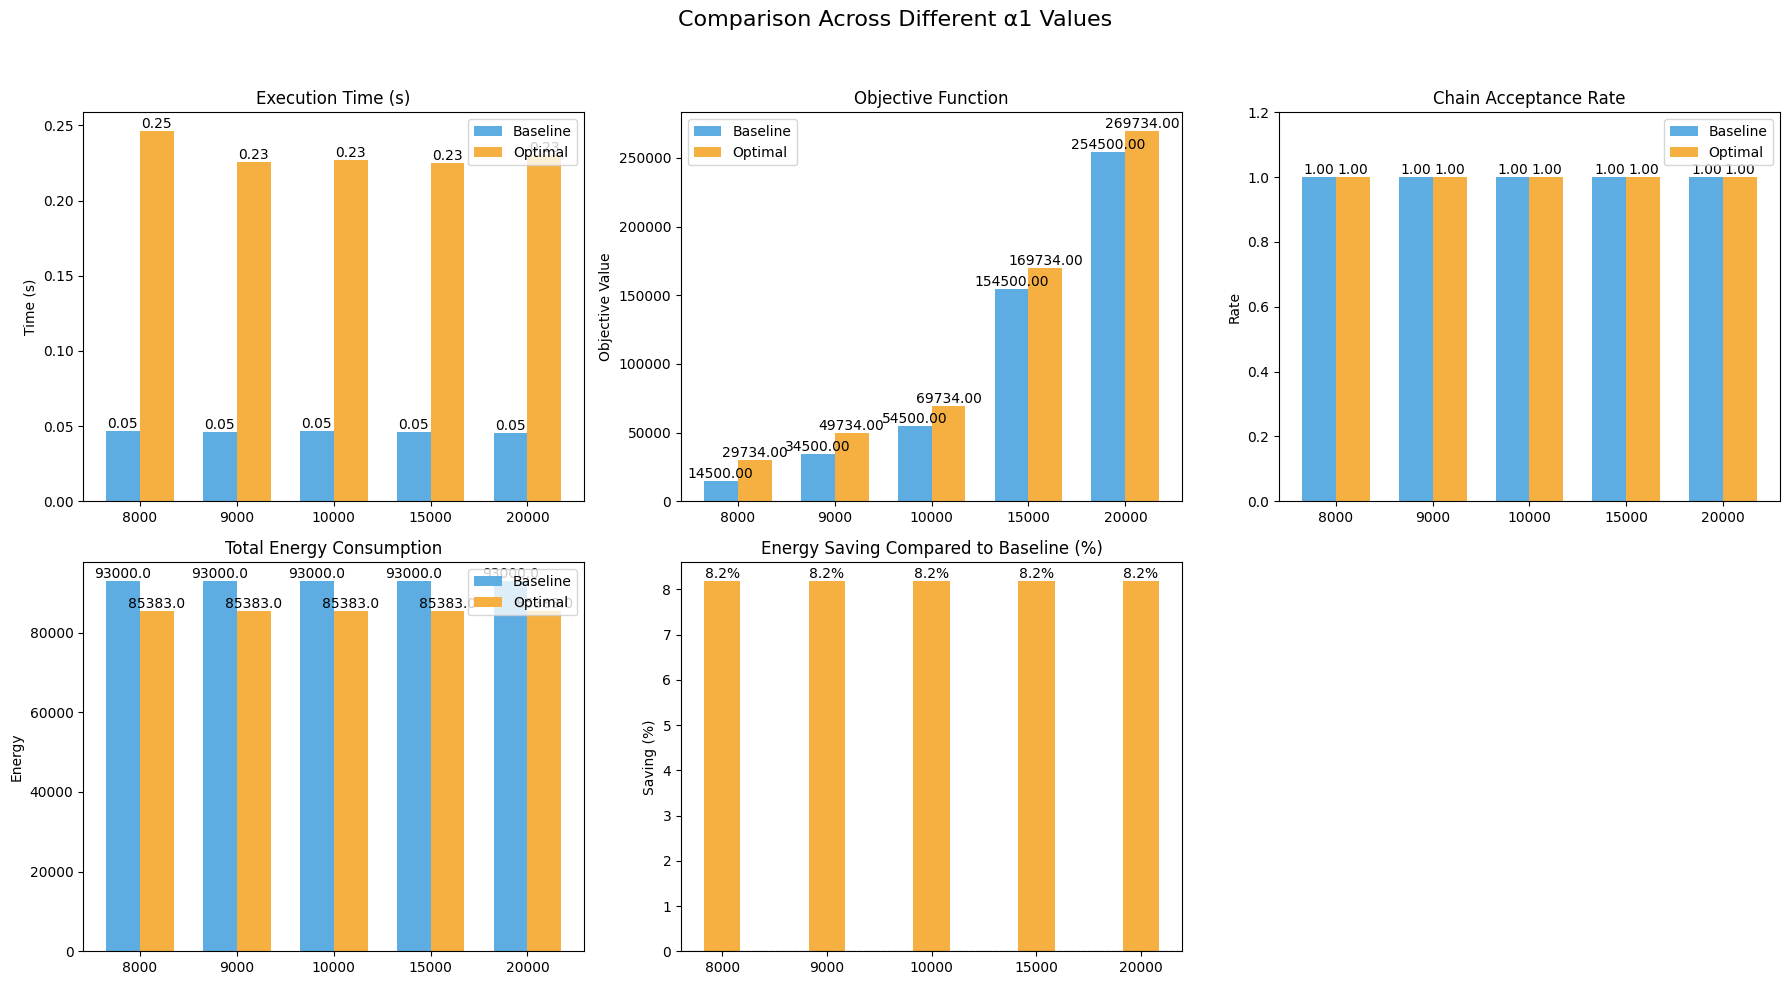

In [4]:
alpha1_list = [8000, 9000, 10000, 15000, 20000]

# Run experiments
results_data = test_different_alpha1(alpha1_list)

# Plot all trend comparisons
visualize_results(alpha1_list, "α1", results_data)



⏱️ Gurobi Runtime: 0.05 seconds

📋 Chain Activation Overview:
Chain 0: ✅ Activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ✅ Activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ✅ Activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ✅ Activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ✅ Activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ✅ Activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ✅ Activated, Tasks: [64, 65, 66]
Chain 9: ✅ Activated, Tasks: [67, 68, 69]
Chain 10: ✅ Activated, Tasks: [70, 71, 72]
Chain 11: ✅ Activated, Tasks: [73, 74, 75]
Chain 12: ✅ Activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Chain 14: ✅ Activated, Tasks: [82, 83, 84]
Chain 15: ✅ Activated, Tasks: [85, 86, 87]
Chain 16: ✅ Activated, Tasks: [88, 89, 90]
Chain 17: ✅ Activated, Tasks: [91, 92, 93]
Chain 18: ✅ Activated, T

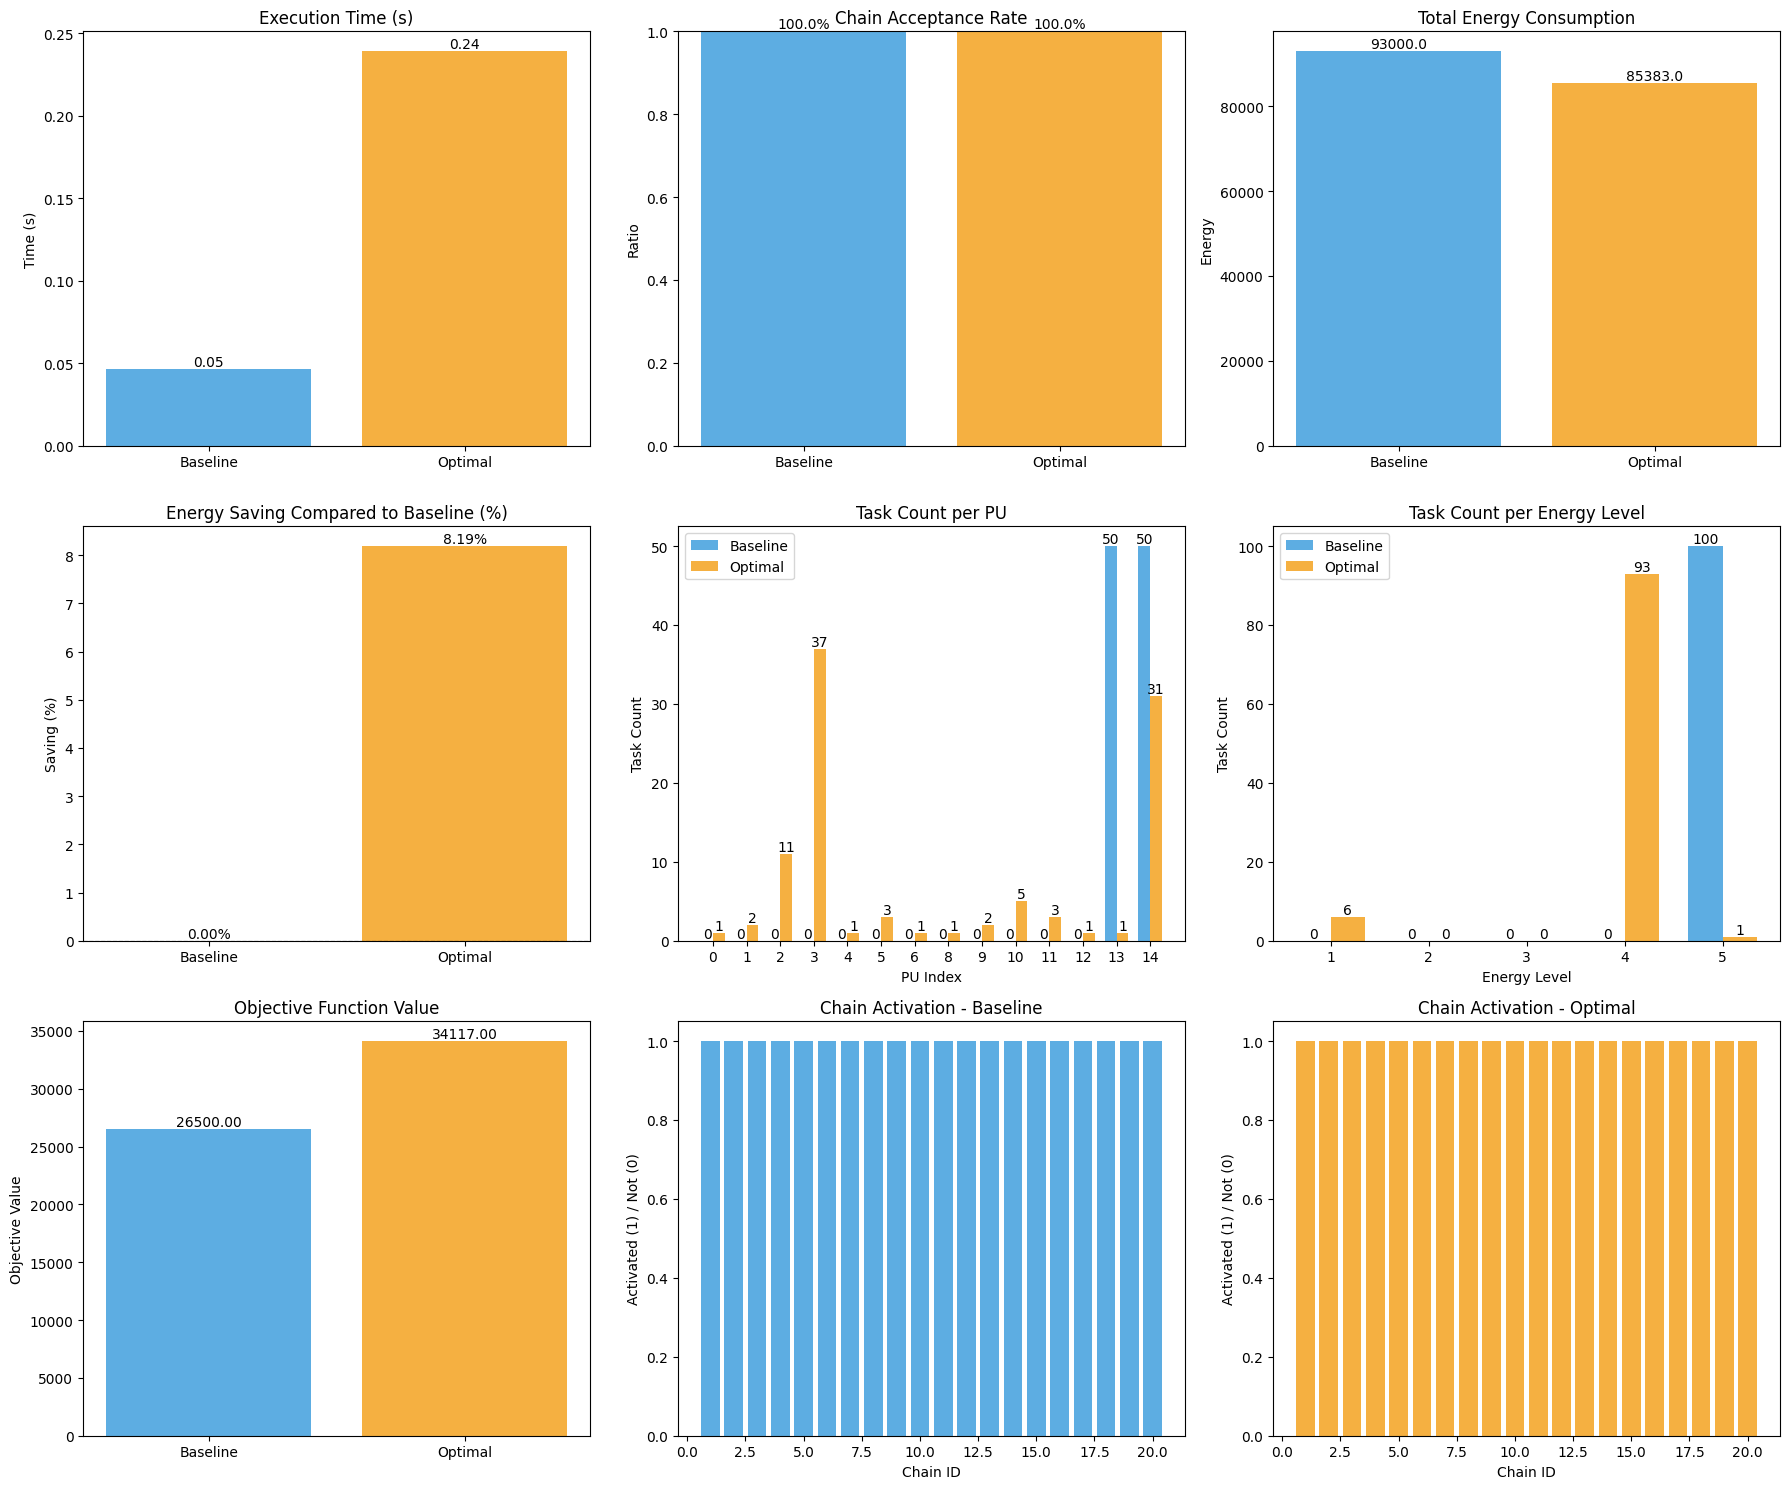

In [5]:
baseline_result = run_gurobi_model(alpha_1=8000, alpha_2=1, alpha_3=1.5, baseline=True)
optimal_result  = run_gurobi_model(alpha_1=8000, alpha_2=1, alpha_3=1.5, baseline=False)

visualize_baseline_vs_optimal_extended_v4_en(baseline_result, optimal_result, num_chains)

⏱️ Gurobi Runtime: 0.05 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ❌ Not activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ❌ Not activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ❌ Not activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ❌ Not activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ✅ Activated, Tasks: [64, 65, 66]
Chain 9: ✅ Activated, Tasks: [67, 68, 69]
Chain 10: ✅ Activated, Tasks: [70, 71, 72]
Chain 11: ✅ Activated, Tasks: [73, 74, 75]
Chain 12: ✅ Activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Chain 14: ✅ Activated, Tasks: [82, 83, 84]
Chain 15: ✅ Activated, Tasks: [85, 86, 87]
Chain 16: ✅ Activated, Tasks: [88, 89, 90]
Chain 17: ✅ Activated, Tasks: [91, 92, 93]


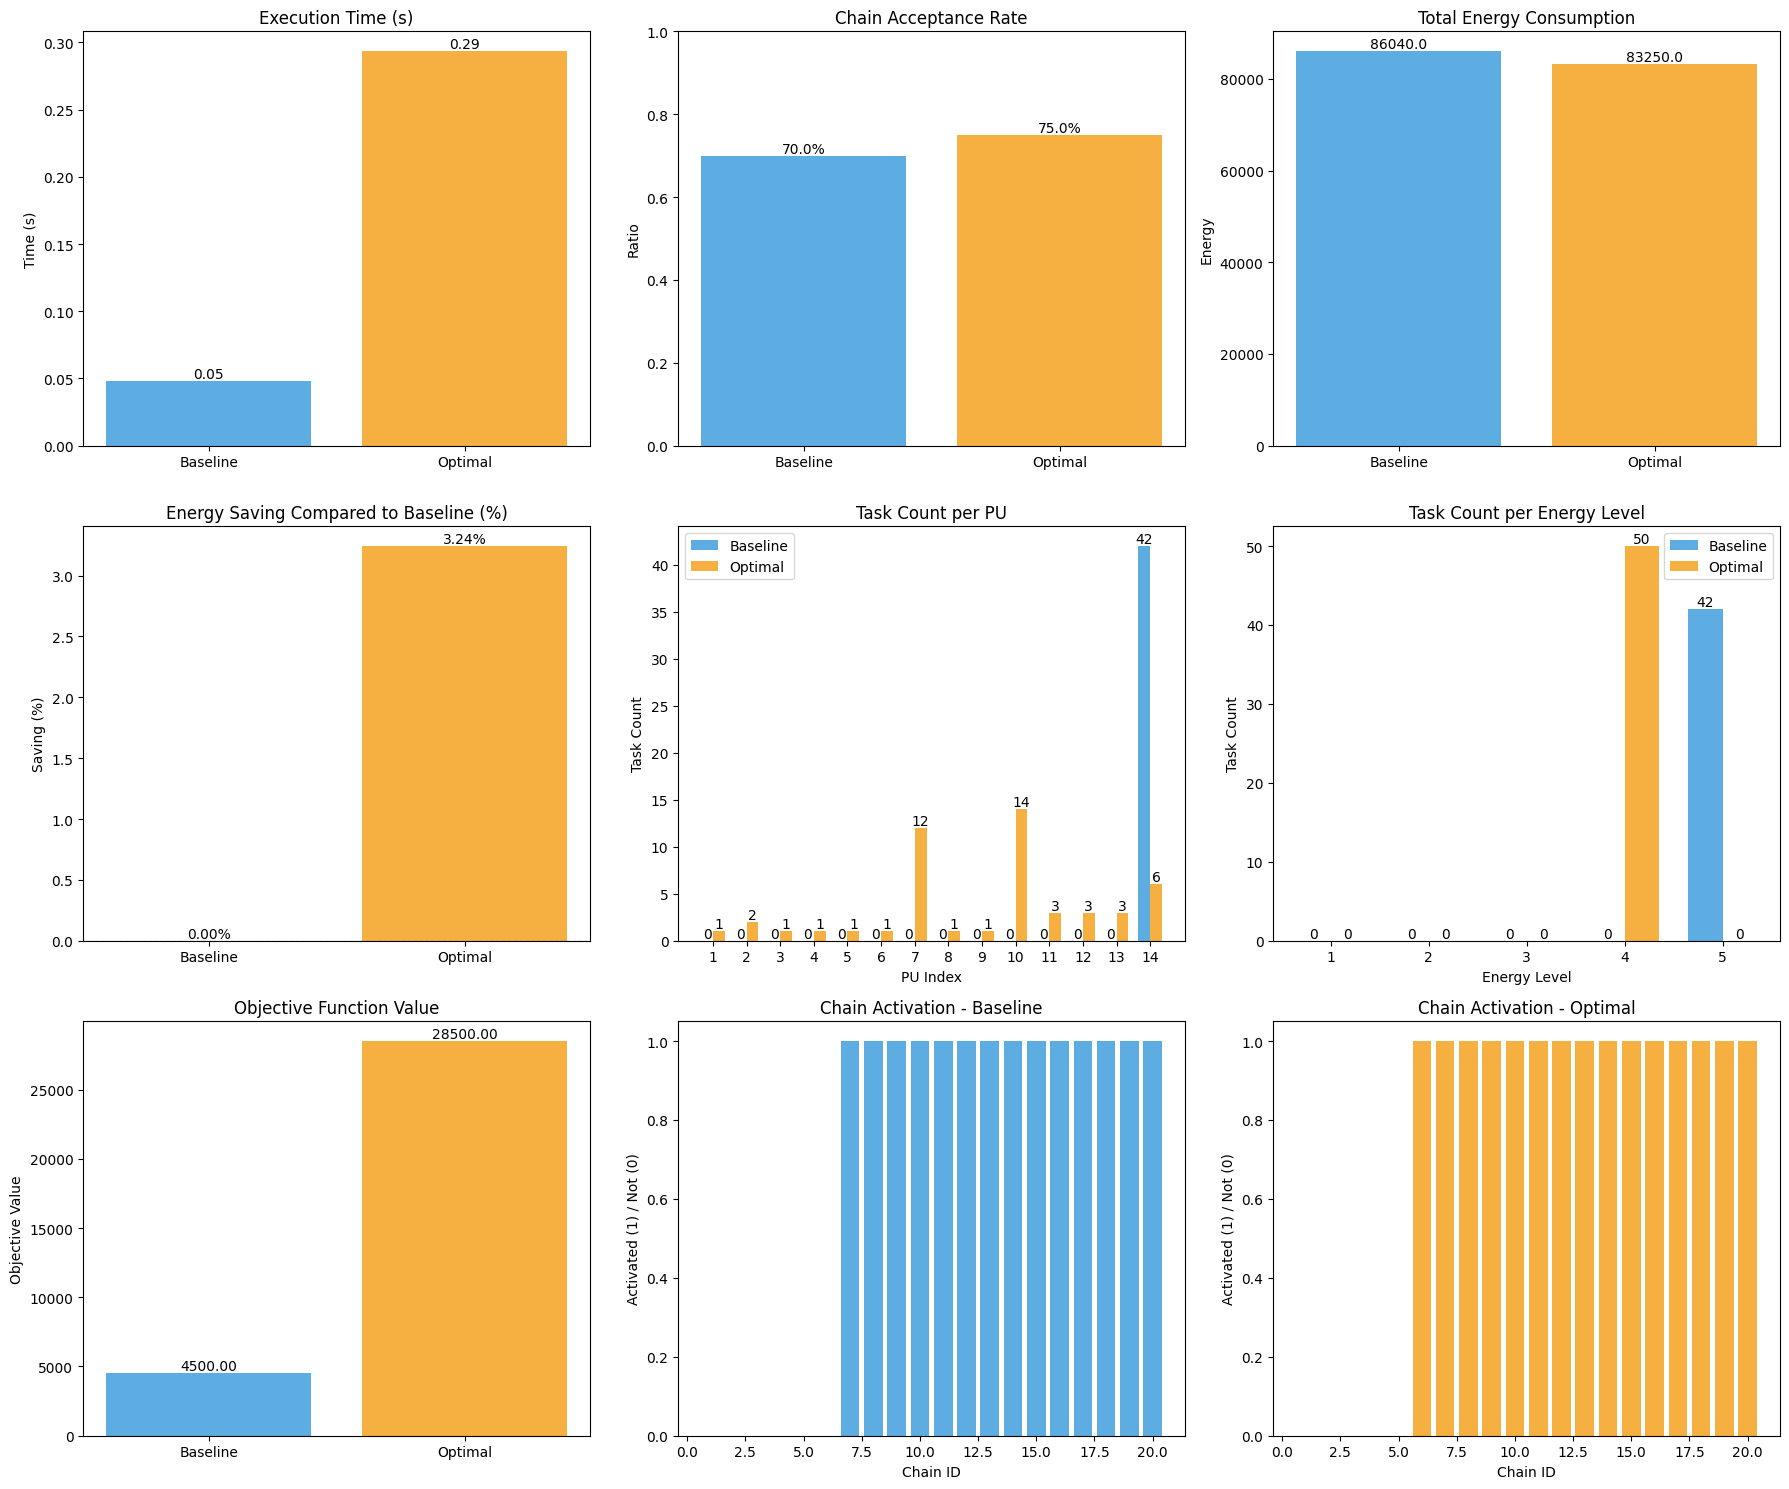

In [6]:
baseline_result = run_gurobi_model(alpha_1=18000, alpha_2=25, alpha_3=1.5, baseline=True)
optimal_result  = run_gurobi_model(alpha_1=16000, alpha_2=40, alpha_3=1.5, baseline=False)

visualize_baseline_vs_optimal_extended_v4_en(baseline_result, optimal_result, num_chains)